In [65]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import math
import openpyxl
from statistics import * 
from IPython.display import display

In [66]:
#returns clean list of corrected concentrations from an excel file (1/14/21 now returns sample names)
def getCorrectedConcentration (file, sheet):
    wb = openpyxl.load_workbook(file)
    df = pd.read_excel(file, sheetname=sheet)
    correctedConc = []
    title = df[0][0].split('-')[0]
    samples = []
    for i in df.index:
        conc = df['Corrected Concentration'][i]
        sample = df[0][i] if isinstance(df[0][i], float) or isinstance(df[0][i], int) else df[0][i].split('-')[0]
        if isinstance(sample, str) and not sample == 'Peak#':
            title = sample
        if title in samples and isinstance(conc, float) and not math.isnan(conc): #math.isnan returns True if conc is nan
            correctedConc.append(conc)
        
        ### NEW!! (01/14/21) Gets and returns sample names as second output of function
        samp = df[0][i]
        if samp == 'Peak#':
            sample_name = df[0][i - 1]
            clean_sample_name = sample_name[0:sample_name.index('-')]
            if clean_sample_name not in samples: samples.append(clean_sample_name)
    return [correctedConc, samples]

### User data entry in cell below (formatting options moved further down)

In [67]:
file = 'C14.xlsx' #file name

#Should be the same from batch to batch
sheet = 'Corrected Concentration' #sheet with corrected concentration data

### Graph data ###
samples = ['WT','KCM272','T137A'] #name of samples (Can delete this line since line 8 does this for you)
samples = getCorrectedConcentration(file, sheet)[1]
print('Samples in order:', samples) #Check sample names
desired_order = ['WT', 'T137A', 'KCM272'] #desired order of columns in bar chart, otherwise, set equal to 'samples'
numVials = [3, 3, 3] ### USER INPUT number of vials per sample in order of appearance 
chains = ['C8','C10','C12_1','C12','C14_1','C14','C16_1','C16','C18_1','C18'] #chain lengths

### Graph text options ###
title = 'BTE Mutants' #graph title
ylabel = 'mg/L FAME' #y axis label

#plt.rcParams["font.family"] = "Times New Roman"
### Python Default
plt.rcParams["font.family"] = 'Arial'

# Check to see if lists samples and numVials are the same length
if len(samples) != len(numVials):
    raise Exception('Length of samples and numVials lists must be the same, hoe!') #love it
    
#avgMat = 0

Samples in order: ['WT', 'KCM272', 'T137A']


In [68]:
#this function arranges data into an appropriate matrix. correctedConc should be clean with no empty spaces
def dataArrange(correctedConc, numTotSamples):
    numChains = int(len(correctedConc)/numTotSamples)
    #print(numTotSamples)
    #print(numChains)
    correctedConc = np.array(correctedConc)
    rearranged = np.zeros((numTotSamples, numChains))
    iterator = 0;
    for sample in range(0,numTotSamples):
        for chain in range(0, numChains):
            rearranged[sample, chain] = correctedConc[iterator]
            iterator = iterator + 1 
    return rearranged.T, rearranged.T.shape

In [69]:
#Calculates average and standard deviation of data
def calcStats(data):
    stats = [mean(data), stdev(data)]
    return stats

In [70]:
#Returns average and standard deviation data in the form of matricies
def dataParse(rearranged, samples, numVials):
    
    #rearranged - the rearranged corrected concentration data table with each row corresponding to a chain length
        #and each column corresponding to a sample vial i.e.
        #
        #         H204A-1  H204A-2  H204A-3    WT-1    WT-2    WT-3
        #   C8 [[    #        #        #        #        #        #    ],
        #  C10  [    #        #        #        #        #        #    ],
        #  C12  [    #        #        #        #        #        #    ],
        #  C14  [    #        #        #        #        #        #    ],
        #  C16  [    #        #        #        #        #        #    ]]
        #
    #samples - list of each type of sample i.e. [H204A, WT]
    #numVials - number of vials per sample in order of appearance i.e. [3, 3]
    
    numChains = int(len(rearranged[0])) #number of chain lengths testing for
    avgMat = np.zeros((numChains, len(samples))) #matrix to store average data
    stdevMat = np.zeros((numChains, len(samples))) #matrix to store stdev data

    row_number = range(0,len(chains))
    column_number = range(0,len(samples))

    for r in row_number:
        #print(rearranged[0][r])
        for c in column_number:
             # rearranged is an array which is set up such that each row contains the concentration for a given chain length
             # for all samples
            avgMat[r,c] = np.mean(rearranged[0][r][c*numVials[c]:(c*numVials[c])+2])
            stdevMat[r,c] = np.std(rearranged[0][r][c*numVials[c]:(c*numVials[c])+2])
        
    return avgMat,stdevMat

In [73]:
#Creates stacked bar chart of chain length distributions
def createBarChart (file, sheet, samples, numVials, chains, ylabel, graphOptions):
    global avgMat
    global scaledMat
    global df_avg
    global df_std
    global df_scaled
    global rearranged
    
    #Unpack graph options
    graphWidth, graphHeight, barWidth, legendLocation, showDataTable, colorScheme = graphOptions
    
    csfont = {'fontname':'Times New Roman'}
    #get concentration data from excel sheet
    concData = getCorrectedConcentration(file,sheet)[0]
    #arrange data into more managable rows and columns
    rearranged = dataArrange(concData, sum(numVials))
    
    #get mean and standard deviation data
    avgMat, stdevMat = dataParse(rearranged, samples, numVials)
    df_avg = pd.DataFrame(avgMat.T, index=samples, columns=chains)
    df_std = pd.DataFrame(stdevMat.T, index=samples, columns=chains)

    #NEW!! (11/25/20) Calculate totals for percent stacked bar chart
    total = avgMat.sum(axis = 0)
    scaledMat = np.transpose(np.true_divide(avgMat, total)*100)
    df_scaled = pd.DataFrame(scaledMat, index=samples, columns=chains)
    
    #NEW!! (01/14/21) 
    #Edits bar order
    df_avg = df_avg.reindex(desired_order)
    df_std = df_std.reindex(desired_order)
    df_scaled = df_scaled.reindex(desired_order)
    #Flips stack order
    df_avg = df_avg.iloc[:, ::-1]
    df_std = df_std.iloc[:, ::-1]
    df_scaled = df_scaled.iloc[:, ::-1]
    
    %matplotlib inline
    
    #NEW!! (01/16/21) plots same stacked bar chart more elegantly
    bar_plot = df_avg.plot(kind = 'bar', stacked = True, rot = 0, figsize = (graphWidth, graphHeight), 
                           title = title, width = barWidth, yerr = df_std, color = colorScheme[::-1])
    bar_plot.set_ylabel(ylabel)
    # Handles legend formatting
    bar_plot_handles, bar_plot_labels = bar_plot.get_legend_handles_labels()
    bar_plot.legend(reversed(bar_plot_handles), reversed(bar_plot_labels), bbox_to_anchor = [1,.5], loc=legendLocation)
    # Shows table with data values if user option set to True
    if showDataTable==True:
        plt.xticks([])
        cell_text = [["{0:.2f}".format(val) for val in df_avg[col]] for col in df_avg]
        bar_plot_table = plt.table(cellText=cell_text, rowLabels=chains, rowColours=colorScheme,
                                   colLabels=samples, cellLoc='center', loc='bottom')
    
    #NEW!! (11/25/20) plot scaled bar chart
    scaled = df_scaled.plot(kind = 'bar', stacked = True, rot = 0, figsize = (graphWidth, graphHeight), 
                            title = title + " Distribtuion", width = barWidth, color = colorScheme[::-1])
    scaled.set_ylabel('Product Distribution')
    # Handles legend formatting
    scaled_handles, scaled_labels = scaled.get_legend_handles_labels()
    scaled.legend(reversed(scaled_handles), reversed(scaled_labels), bbox_to_anchor = [1,.5], loc=legendLocation)
    # Shows table with data values if user option set to True
    if showDataTable==True:
        plt.xticks([])
        cell_text = [["{0:.2f}%".format(val) for val in df_scaled[col]] for col in df_scaled]
        scaled_plot_table = plt.table(cellText=cell_text, rowLabels=chains, rowColours=colorScheme,
                                      colLabels=samples, cellLoc='center', loc='bottom')

### User enters graph options (dimensions, colors, element placement, etc.) below

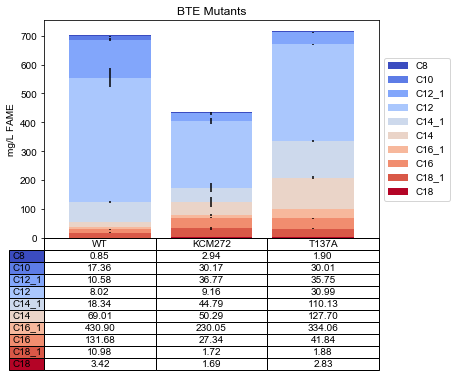

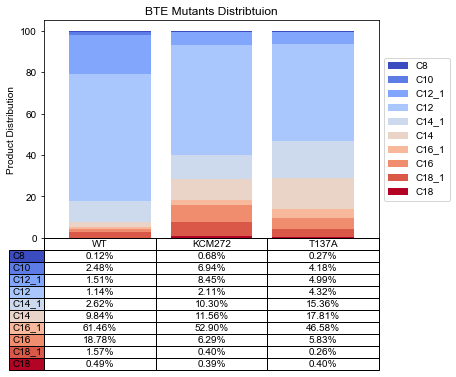

In [75]:
### Graph format options ###
graphWidth = 6 #Default 6.0
graphHeight = 4 #Default 4.0
barWidth = 0.8 #Default 0.8
legendLocation = 'center left' #Default 'best' or Choose: 'upper right/center/left', 'lower right/center/left'
showDataTable = True #Toggles data table for bar charts

### Graph color options ###
# Optional: Replace with '<color map name>' from matplotlib.org/3.1.1/gallery/color/colormap_reference.html
colorMap = 'coolwarm' #Default: tab10 (kinda ugly IMHO)
# Can adjust max/min usable color within the range (min=0, max=1). Can also reverse i.e. [1, 0] 
colorRange = [0,1]  #Default: [0,1]
colorScheme = pl.cm.get_cmap(colorMap)(np.linspace(colorRange[0],colorRange[1],len(chains)))

# Aggregate graph options
graphOptions = [graphWidth, graphHeight, barWidth, legendLocation, showDataTable, colorScheme]

createBarChart(file, sheet, samples, numVials, chains, ylabel, graphOptions)

In [15]:
num_Exp = len(samples)
library_summary = np.zeros((num_Exp,2)) 
print(library_summary)

[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


In [117]:
# Populate library_summary array with C12 fraction and total titer

for sample in range(0,num_Exp):
    titer = 0
    for analyte in avgMat:
        titer = titer + analyte[sample]
        
    library_summary[sample, 1] = titer
    

# Populate library_summary array with C12 fraction and total titer

for sample in range(0,num_Exp):
    C14_titer = 0
    C12_titer = 0
    titer = 0
    counter = 1
    for analyte in avgMat[2:6]: #looking at C12 and C14 fractions only
        if counter < 3:
            C12_titer = C12_titer + analyte[sample]
        
        elif counter >= 3:
            C14_titer = C14_titer + analyte[sample]
            
        counter = counter+1
    
    ratio = C12_titer/C14_titer
    library_summary[sample, 0] = ratio

In [118]:
a = np.round(library_summary,2)

In [119]:
np.trunc(a*10**1)/(10**1)

array([[   6.4,  701.1],
       [   1.5,  717.1],
       [   2.7,  434.9]])

In [120]:
WT_slice = avgMat[:,0]
WT_sum = np.sum(WT_slice)

KCM272_slice = avgMat[:,1]
KCM272_sum = np.sum(KCM272_slice)
T137A_slice = avgMat[:,2]
T137A_sum = np.sum(T137A_slice)

In [121]:
WT_dist = []
for i in WT_slice:
    fraction = i/WT_sum
    WT_dist.append(fraction)


KCM272_dist = []
for i in KCM272_slice:
    fraction = i/KCM272_sum
    KCM272_dist.append(fraction)
    
T137A_dist = []
for i in T137A_slice:
    fraction = i/T137A_sum
    T137A_dist.append(fraction)
    

In [122]:
count = 0

C12_1 = []
C12 = []
C14_1 = []
C14 = []
C16_1 = []
C16 = []
C18 = []
C18_1 = []
for x, y, z in zip(WT_dist, KCM272_dist, T137A_dist):
    if count == 2:
        C12_1.append(x)
        C12_1.append(y)
        C12_1.append(z)
    elif count == 3:
        C12.append(x)
        C12.append(y)
        C12.append(z)
    elif count == 4:
        C14_1.append(x)
        C14_1.append(y)
        C14_1.append(z)
    elif count == 5:
        C14.append(x)
        C14.append(y)
        C14.append(z)
    elif count == 6:
        C16_1.append(x)
        C16_1.append(y)
        C16_1.append(z)
    elif count == 7:
        C16.append(x)
        C16.append(y)
        C16.append(z)
    elif count == 8:
        C18_1.append(x)
        C18_1.append(y)
        C18_1.append(z)
    elif count == 9:
        C18.append(x)
        C18.append(y)
        C18.append(z)
    
    count = count + 1

In [123]:
C12

[0.61456889363977729, 0.4658480644946732, 0.52895014115762862]

In [124]:
C12_1

[0.18780856953065239, 0.058345555627997404, 0.062862704875961753]

In [125]:
C18_1

[0.024766519062245966, 0.04184719495947118, 0.069377648865328739]

In [126]:
T137A_dist

[0.0038883365668561133,
 0.0039518057192873511,
 0.062862704875961753,
 0.52895014115762862,
 0.1156357152428286,
 0.102990062689392,
 0.021053952131148586,
 0.084539391396596747,
 0.069377648865328739,
 0.0067502413549714634]

In [127]:
WT_dist

[0.0048793924100603795,
 0.015658726339826675,
 0.18780856953065239,
 0.61456889363977729,
 0.098424242792116132,
 0.026158892037864492,
 0.01143706171567359,
 0.015085652468402027,
 0.024766519062245966,
 0.0012120500033810915]

In [128]:
chains = ['C8','C10','C12_1,','C12','C14_1','C14','C16_1','C16','C18_1','C18']

In [129]:
import pickle

In [130]:
pickle.dump([T137A_dist,WT_dist,chains], open('T137A_distribution.p', 'wb'))

### This is the old code for making the stacked bar chart. Keeping this here in case we need to use it again for any reason.
    plot normal bar chart
    %matplotlib inline
    N = len(samples)
    ind = np.arange(N)
    firstMean = df_avg.loc[0,:]
    firstStd = df_std.loc[0,:]
    plt.figure(figsize=(graphWidth,graphHeight))
    fistplot = plt.bar(ind, firstMean, width=.1, yerr=firstStd, label=chains[0])
    sumMeans = [0]*len(samples)
    for chain in range(1,len(chains)):
        chainMean = df_avg.loc[chain,:]
        prevChainMean = df_avg.loc[chain-1,:]
        for i in range(len(sumMeans)):
            sumMeans[i] = sumMeans[i] + prevChainMean[i]
        chainStd = df_std.loc[chain,:]
        plt.bar(ind, chainMean, width=.1, bottom=sumMeans, yerr=chainStd, label=chains[chain])
    plt.xticks(ind,desired_order)
    plt.legend(bbox_to_anchor = [1,.5], loc='center left')
    plt.suptitle(title)
    plt.ylabel(ylabel)
    plt.show
    
### Alternate version with fewer lines of code and includes colored data table
    %matplotlib inline
    colors = []
    ind = np.arange(len(samples)) + 0.3
    nump = df_avg.T.values
    nump_std = df_std.T.values
    y_offset = np.zeros(len(samples))
    cell_text = []
    for chain in range(len(nump)):
        plt.bar(ind, nump[chain], width=barWidth, bottom=y_offset, yerr=nump_std[chain])
        colors.append('C'.strip() + str(chain))
        y_offset = y_offset + nump[chain]
        cell_text.append(['%1.2f'% val for val in nump[chain]])
    cell_text.reverse()
    colors = colors[::-1]
    the_table = plt.table(cellText = cell_text, 
                          rowLabels = chains, 
                          rowColours=colors, 
                          colLabels = samples, 
                          loc = 'bottom')
    plt.xticks([])
    #plt.xticks(ind, samples)
    plt.title(title)
    plt.show()
    
### Displays formatted DataFrame for df_avg and df_scaled
    df_avg_formatted = pd.DataFrame([["{0:.2f}".format(val) for val in df_avg[col]] for col in df_avg],
                                index=df_avg.T.index, 
                                columns=list(df_avg.T))
    df_scaled_formatted = pd.DataFrame([["{0:.2f}%".format(val) for val in df_scaled[col]] for col in df_scaled], 
                                       index=df_scaled.T.index, 
                                       columns=list(df_scaled.T)).style
    display(df_avg_formatted)
    display(df_scaled_formatted)
    
### Default color scheme
    colorScheme = ['C'.strip() + str(x) for x in range(len(chains))]